In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Skipping, found downloaded files in "./covid19-radiography-database" (use force=True to force download)


In [ ]:
import tensorflow as tf                                                               # библиотека Tensorflow
import keras                                                                          # библиотека Keras
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, Rescaling     # cлои библиотеки Keras
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate             # cлои библиотеки Keras
from keras.layers import Rescaling, Resizing                                          # cлои библиотеки Keras
from keras.models import Model, Sequential                                            # конструкторы построения моделей библиотеки Keras

from keras.optimizers import Adam                                                     # оптимизатор Adam
from keras.preprocessing.image import  load_img                                       # загрузка изображений
from keras.utils import to_categorical                                                # преобразует вектор класса (целые числа) в двоичную матрицу класса

import random                                                                         # генератор случайных чисел

import numpy as np                                                                    # библиотека линейной алгебры
import pandas as pd                                                                   # библиотека обработки табличных данных
import os                                                                             # библиотека работы с функциями операционной системы, в том числе с файлами
import albumentations as A                                                            # библиотека аугментации изображений (https://albumentations.ai/)

import matplotlib.pyplot as plt                                                       # библиотека для рисования графиков
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Пути к изображениям и маскам
img_path = "/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images"
mask_path = "/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks"

In [ ]:
# Получаем списки файлов
img_files = sorted([os.path.join(img_path, f) for f in os.listdir(img_path) if f.endswith(".png")])
mask_files = sorted([os.path.join(mask_path, f) for f in os.listdir(mask_path) if f.endswith(".png")])

In [ ]:
# Проверка, что файлы парные
assert len(img_files) == len(mask_files), "Количество изображений и масок не совпадает."
assert all(os.path.basename(img).split('.')[0] == os.path.basename(mask).split('.')[0] for img, mask in zip(img_files, mask_files)), "Файлы не парные."

In [ ]:
# print(f"Количество изображений: {len(img_files)}")

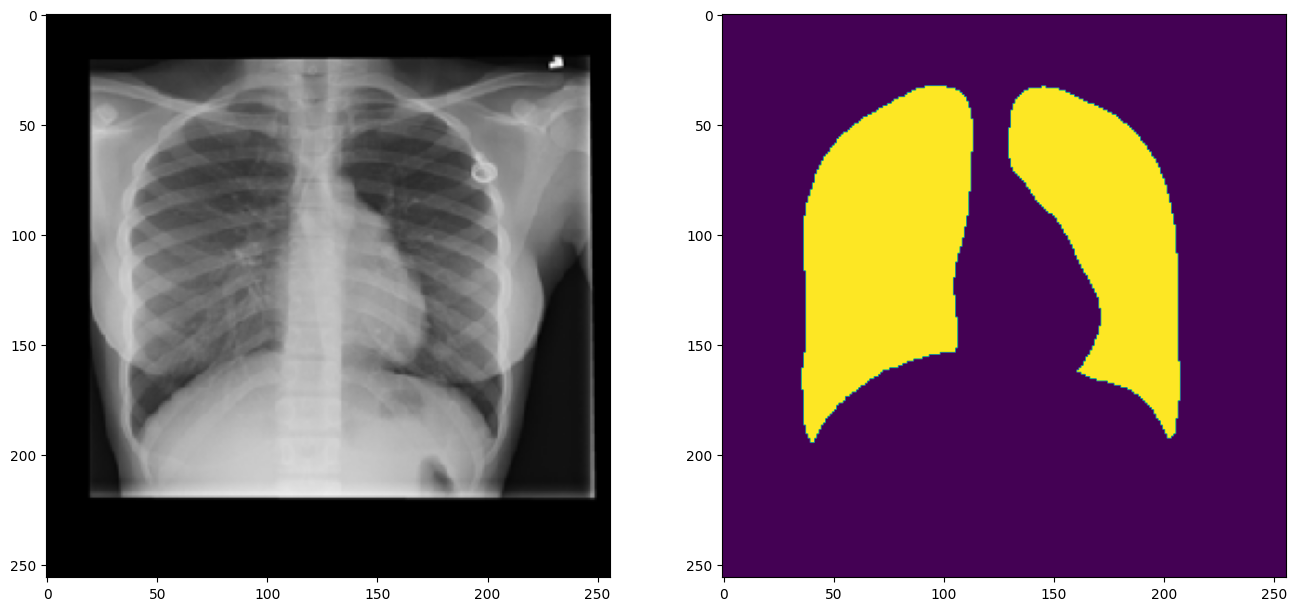

In [ ]:
original_image = os.path.join(img_path, 'Normal-1.png')       # путь до ориганального изображения
label_image_semantic = os.path.join(mask_path, 'Normal-1.png') # путь до маски

fig, axs = plt.subplots(1, 2, figsize=(16, 8))                          # задаем область для построения (канвас)

img = np.array(load_img(original_image, target_size=(256, 256), color_mode='rgb'))   # загружаем оригинальное изображение как RGB с 3 каналами
mask = np.array(load_img(label_image_semantic, target_size=(256, 256), color_mode='grayscale'))  # загружаем маску как "отеннки серого", т.е. в один канал

axs[0].imshow(img)  # отрисовываем оригинальное изображение
axs[0].grid(False)

axs[1].imshow(mask) # отрисовываем маску (одноканальное изображение, каждый класс отображается как отдельный цвет)
axs[1].grid(False)

In [ ]:
NUM_CLASSES = 2
IMG_SIZE = (160, 160)

In [ ]:
batch_size = 16
img_size = IMG_SIZE
num_classes = NUM_CLASSES

In [ ]:
# Генератор для перебора данных (в виде массивов Numpy)

class datasetGenerator(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_path, target_img_path = None, num_classes = NUM_CLASSES, validation = False):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_path = input_img_path
        self.target_img_path = target_img_path
        self.validation = validation


    def __len__(self):
        """Возвращает число мини-батчей обучающей выборки"""
        return len(self.target_img_path) // self.batch_size


    def __getitem__(self, idx):
        """Возвращает кортеж (input, target) соответствующий индексу пакета idx"""

        # Формируем пакеты из ссылок путем среза длинной в batch_size и возвращаем пакет по индексу
        batch_input_img_path = self.input_img_path[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_target_img_path = self.target_img_path[idx*self.batch_size:(idx+1)*self.batch_size]

        # Создадим массив numpy, заполненный нулями, для входных данных формы (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, 3) и типа данных float32
        x = np.zeros((self.batch_size, *self.img_size, 3), dtype="float32")

        # Создадим массив numpy, заполненный нулями, для выходных данных формы (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, 1) и типа данных uint8
        y = np.zeros((self.batch_size, *self.img_size, num_classes), dtype="uint8")

        # В цикле заполняем массивы с изображениями x и y
        # Перебираем пакеты из путей batch_input_img_path и batch_target_img_path к изображениям
        # zip возвращает для нескольких последовательностей список кортежей из элементов последовательностей с одинаковыми индексами
        for _, paths in enumerate(zip(batch_input_img_path, batch_target_img_path)):

            # Загружаем изображение и маску используя путь файловой системы
            img = np.array(load_img(paths[0], target_size=self.img_size, color_mode='rgb'))         # 3 канала для изображения
            mask = np.array(load_img(paths[1], target_size=self.img_size, color_mode='grayscale'))  # 1 канал для маски

            if self.validation == False:
                # Применяем аугментацию для проверочной выборки (p - вероятность применения, 0.5 - для каждого второго изображения)
                transform = A.Compose([ # определяем функцию аугментации
                                A.HorizontalFlip(p=0.5), # Отражение изображения по горизонтали и вертикали
                                A.RandomRotate90(always_apply=False, p=0.5) # Случайный поворот на 90 градусов
                                 ])
                transformed = transform(image=img, mask=mask) # применяем функцию аугментации в изображению и маске
                img = transformed["image"]
                mask = transformed["mask"]

            x[_] = img / 255 # нормализуем изображение

            # Преобразуем маску из значений [0, 255] в [0, 1]
            mask = mask // 255

            y[_] = to_categorical(mask, num_classes=num_classes) # преобразует маску из целых чисел в двоичную матрицу класса

        return x, y


In [ ]:
val_samples = int(0.1 * len(img_files))
print(f"Количество валидационных изображений: {val_samples}")

Количество валидационных изображений: 1019


In [ ]:
# Расщепим наш датасет  на обучающую и проверочные выборки
train_input_img_path = img_files[:-val_samples]
train_target_img_path = mask_files[:-val_samples]
val_input_img_path = img_files[-val_samples:]
val_target_img_path = mask_files[-val_samples:]

In [ ]:
train_gen = datasetGenerator(batch_size, img_size, train_input_img_path, train_target_img_path, num_classes)

val_gen = datasetGenerator(batch_size, img_size, val_input_img_path, val_target_img_path, num_classes, validation = True)

In [ ]:
def convolution_operation(entered_input, filters=64):

    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    acti1 = ReLU()(batch_norm1)


    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(acti1)
    batch_norm2 = BatchNormalization()(conv2)
    acti2 = ReLU()(batch_norm2)

    return acti2

In [ ]:
# Функция кодировщика
# На входе 2 параметра - предыдущий слой и число фильтров (генерируемых карт признаков)
def encoder(entered_input, filters=64):

    encod1 = convolution_operation(entered_input, filters)  # функция свертки - 2 синих блока
    MaxPool1 = MaxPooling2D(strides = (2,2))(encod1)        # зеленый блок
    return encod1, MaxPool1 # функция возвращает латеральное соединение и выход из слоя

# Функция декодировщика
# На входе 3 параметра - предыдущий слой и латеральное соединение и число фильтров (генерируемых карт признаков)
def decoder(entered_input, skip, filters=64):
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input) # красный блок
    Connect_Skip = Concatenate()([Upsample, skip])                                        # белый блок (объединение латерального соединения и выхода предыдущего слоя)
    out = convolution_operation(Connect_Skip, filters)                                    # функция свертки - 2 синих блока
    return out # функция возвращает выход из слоя

In [ ]:
# Наша интерпретация модели U-net
def U_Net(img_size, num_classes):
    # Входной слой - желтый блок
    inputs = Input(img_size)

    # Задаем блоки кодировщика и латеральные соединения
    skip1, encoder_1 = encoder(inputs, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)

    # Бутылочное горлышка задаем 2-мя синими блоками
    conv_block = convolution_operation(encoder_4, 64*16)

    # Задаем блоки декодировщика и передаем ему латеральные соединения от кодировщиков
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)

    # Выходной слой (фиолетовый блок), его конфигурация зависит от решаемой задачи
    outputs = Conv2D(num_classes, kernel_size = (1, 1), padding="same", activation="softmax")(decoder_4)

    model = Model(inputs, outputs)
    return model

In [ ]:
num_classes = NUM_CLASSES # 2 класса объектов
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3) # размер к которому преобразуем изображение, 3 канала - RGB
model = U_Net(input_shape, num_classes) # инициализируем модель

In [ ]:
model.compile(
    optimizer='adam' ,
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint("segmentation.keras", monitor='val_loss', save_best_only=True)
]

In [ ]:
model.summary() # отчет о структуре модели

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 160, 160, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 160, 160, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 160, 160, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 160, 160, 64)   │         36,928 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 160, 160, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 160, 160, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 80, 80, 64)     │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 80, 80, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 80, 80, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 80, 80, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 80, 80, 128)    │        147,584 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 80, 80, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 80, 80, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 40, 40, 128)    │              0 │ re_lu_3[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 40, 40, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,055,362 (118.47 MB)

 Trainable params: 31,043,586 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
epochs = 10
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks
                   )

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


573/573 ━━━━━━━━━━━━━━━━━━━━ 302s 410ms/step - accuracy: 0.9607 - loss: 0.0993 - val_accuracy: 0.9839 - val_loss: 0.0423
Epoch 2/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 233s 406ms/step - accuracy: 0.9895 - loss: 0.0266 - val_accuracy: 0.9897 - val_loss: 0.0259
Epoch 3/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 263s 407ms/step - accuracy: 0.9914 - loss: 0.0214 - val_accuracy: 0.9921 - val_loss: 0.0202
Epoch 4/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 225s 392ms/step - accuracy: 0.9921 - loss: 0.0196 - val_accuracy: 0.7912 - val_loss: 1.7568
Epoch 5/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 270s 405ms/step - accuracy: 0.9909 - loss: 0.0234 - val_accuracy: 0.9933 - val_loss: 0.0169
Epoch 6/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 237s 413ms/step - accuracy: 0.9929 - loss: 0.0175 - val_accuracy: 0.9939 - val_loss: 0.0156
Epoch 7/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 249s 391ms/step - accuracy: 0.9935 - loss: 0.0159 - val_accuracy: 0.9101 - val_loss: 0.5488
Epoch 8/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 262s 391ms/step - accuracy: 0.9928 - loss: 0.01

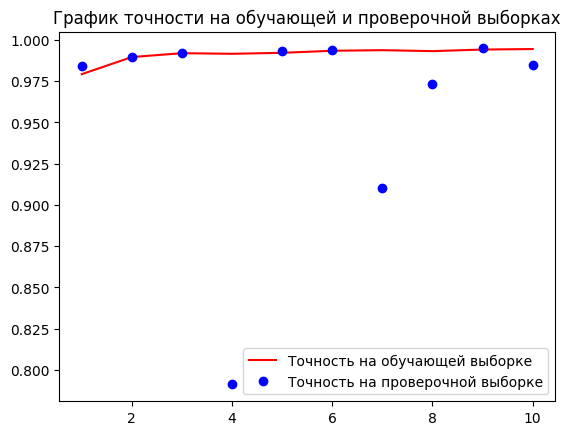

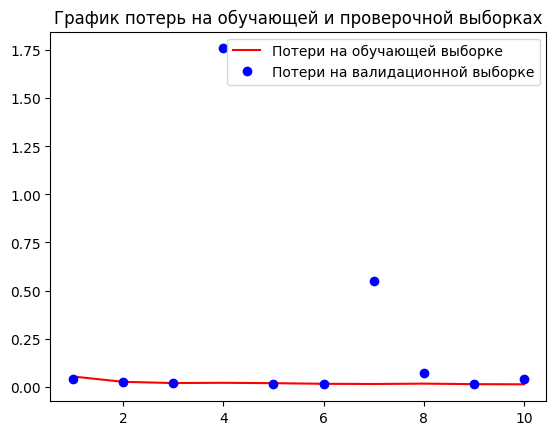

In [ ]:
acc = history.history['accuracy']                              # данные о точности на обучающей выборке
val_acc = history.history['val_accuracy']                      # данные о точности на проверочной выборке
loss = history.history['loss']                                             # данные об ошибке на обучающей выборке
val_loss = history.history['val_loss']                                     # данные об ошибке на проверочной выборке
epochs = range(1, len(acc) + 1)                                            # массив со значениями для оси абсцисс (Х)
plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')          #  строим график точность на обучающей выборке
plt.plot(epochs, val_acc, 'bo', label='Точность на проверочной выборке')   #  строим график точность на проверочной выборке
plt.title('График точности на обучающей и проверочной выборках')           #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.figure()                                                               #  создаем новую фигуру (полотно для графика)
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           #  строим график потерь (ошибки) на обучающей выборке
plt.plot(epochs, val_loss, 'bo', label='Потери на валидационной выборке')  #  строим график потерь на проверочной выборке
plt.title('График потерь на обучающей и проверочной выборках')             #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.show()

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[0])            # отображаем картинку
    plt.imshow(display_list[i],alpha=0.8)  # отображаем маску с прозрачностью 80%
    plt.axis('off')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


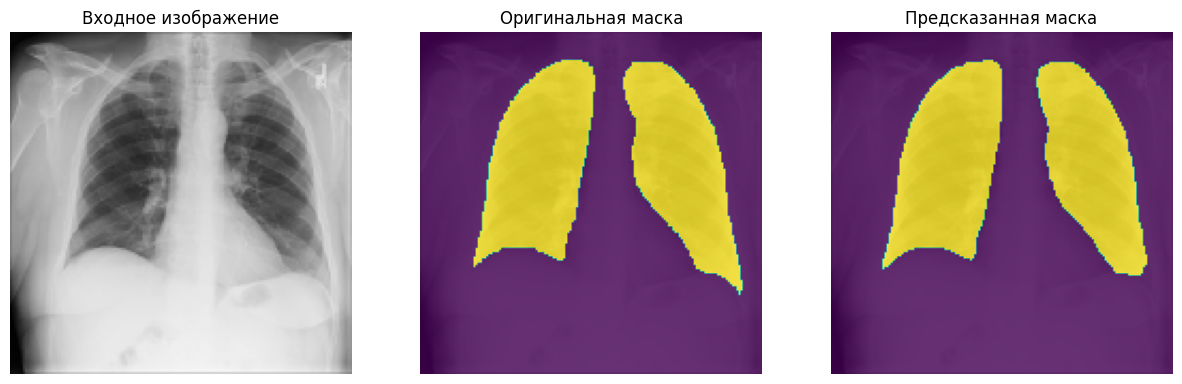

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


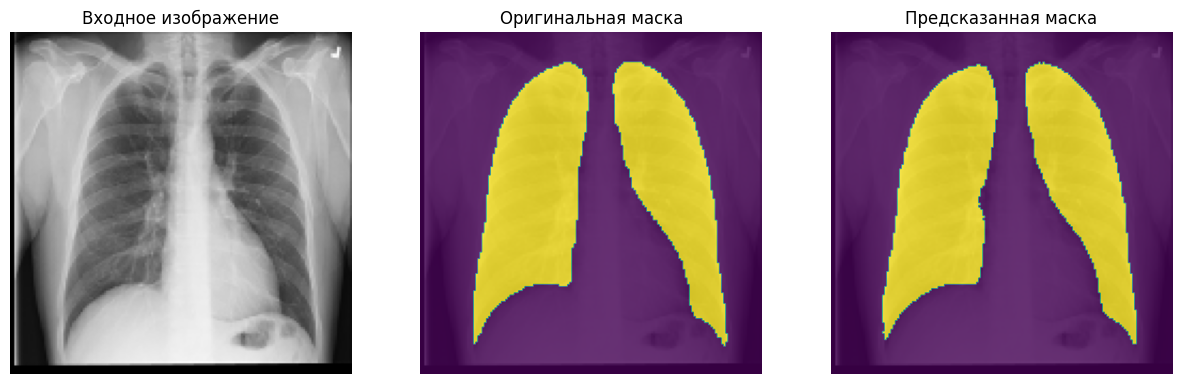

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


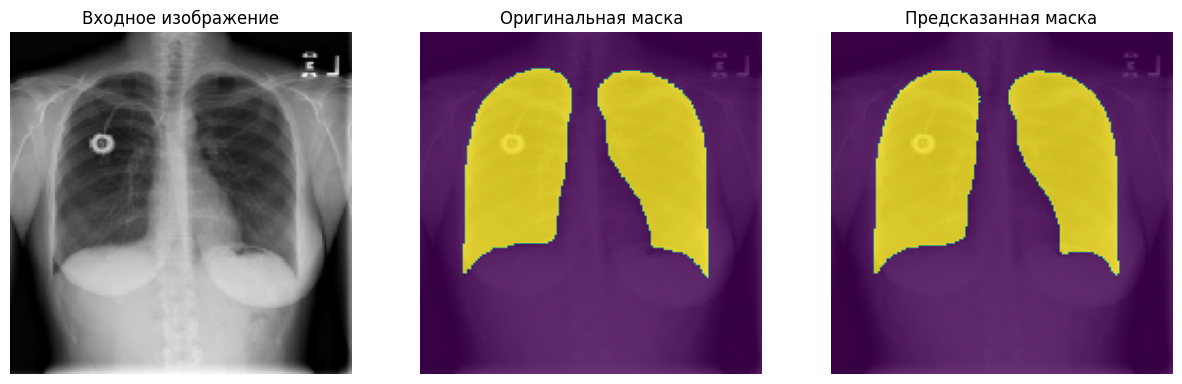

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


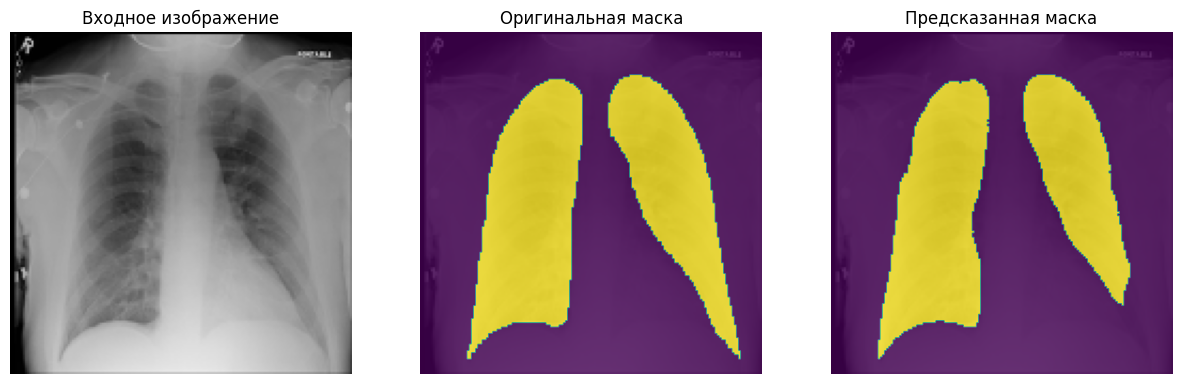

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


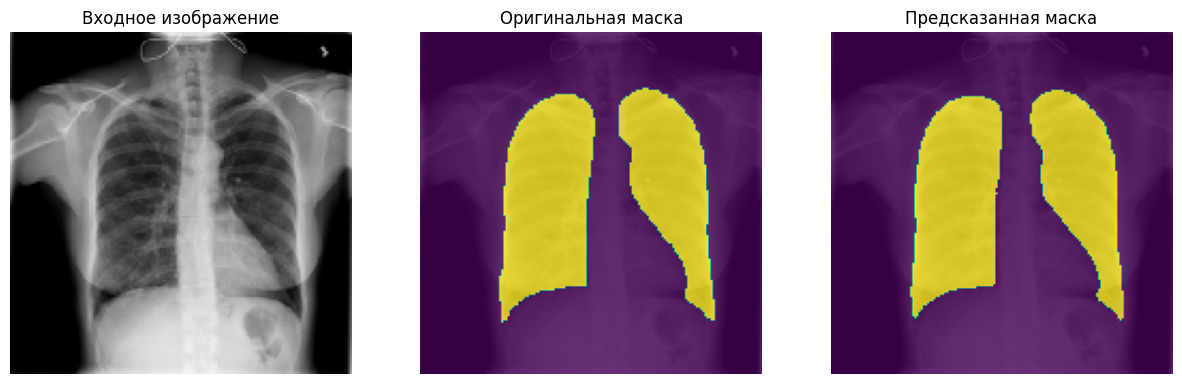

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


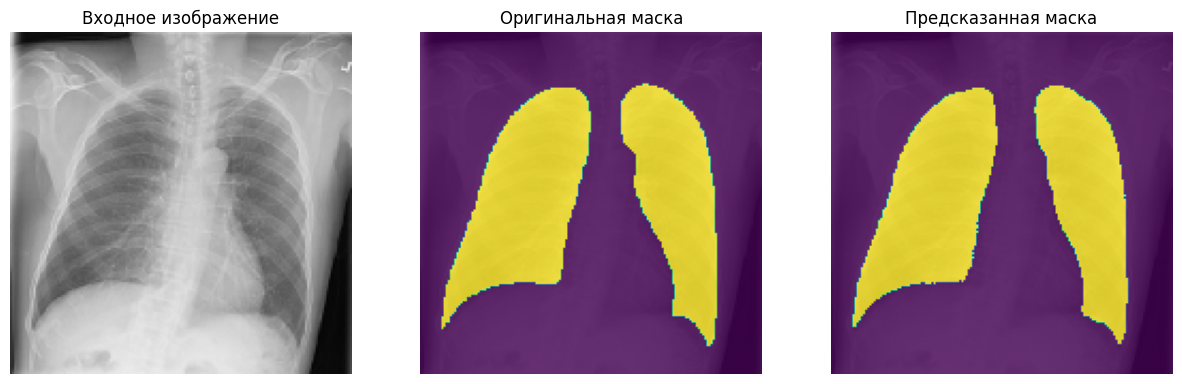

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


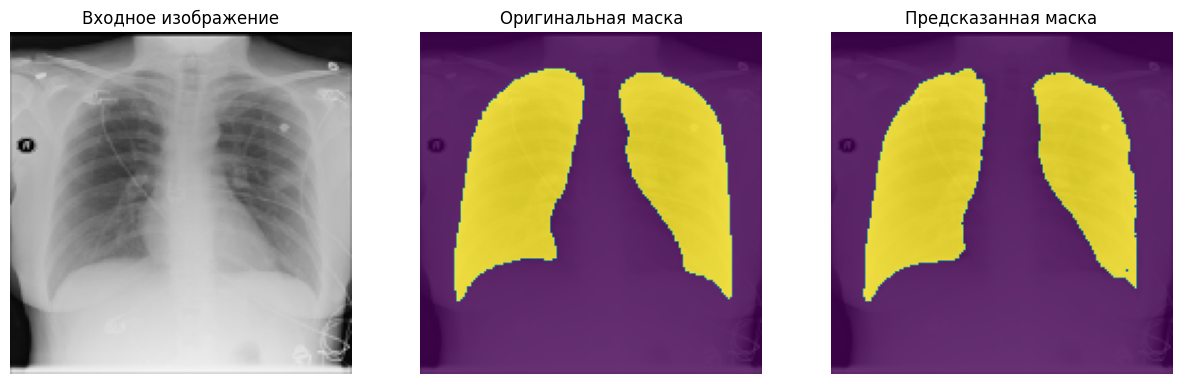

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


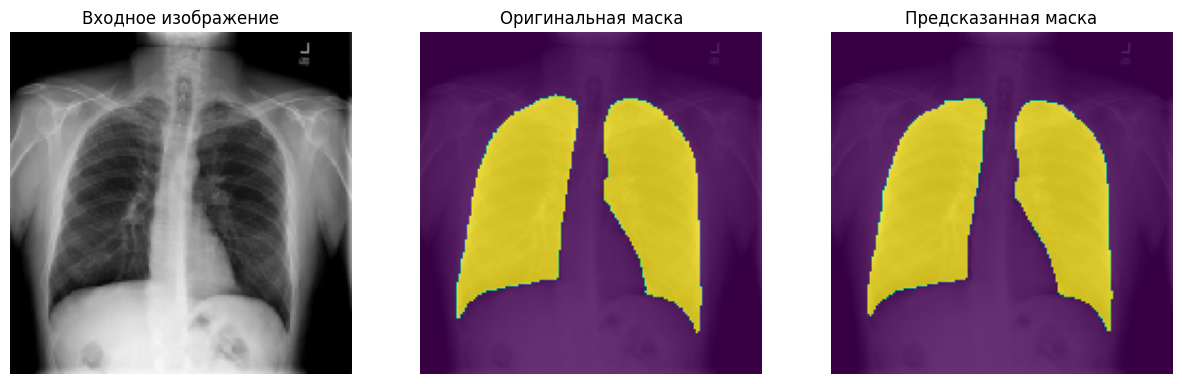

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


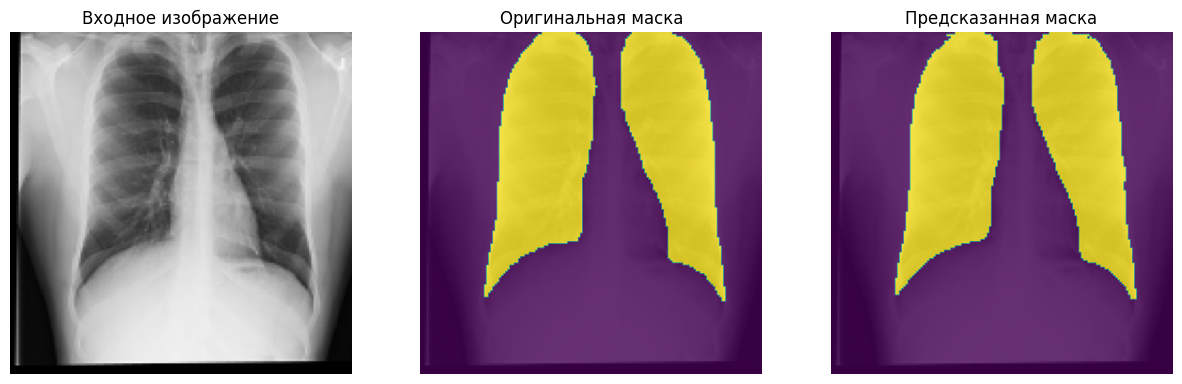

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


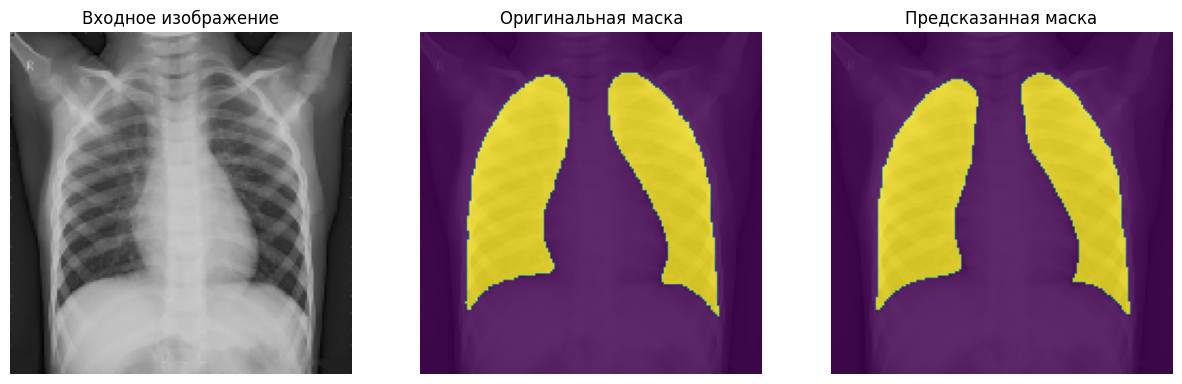

In [ ]:
for index in range(10):
    img = np.array(load_img(val_input_img_path[index], target_size=(160, 160), color_mode='rgb')) # загружаем картинку для предсказания
    mask = np.array(load_img(val_target_img_path[index], target_size=(160, 160), color_mode='grayscale')) # загружаем маску для сравнения с предсказанием

    # Запускаем модель в режиме предсказания
    test = model.predict(np.expand_dims(img, 0) / 255)

    # Выбираем наиболее веротный класс
    test = np.argmax(test, axis=-1)

    display([img.reshape(1, 160, 160, 3)[0], mask, test[0]])  # передаем в функцию display изображение, оригинальную маску и предсказанную